### Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.special import boxcox1p
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.pipeline import Pipeline
from yellowbrick.regressor import PredictionError, ResidualsPlot
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Read data

In [39]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
sub = pd.read_csv('Data/sample_submission.csv')

In [40]:
print('Train Data: ')
display(train.head())
print('Test Data: ')
display(test.head())
print('sample submission: ')
display(sub.head())

Train Data: 


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,42,20,RL,115.0,16905,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,170000
1,1075,20,RL,74.0,8556,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,194000
2,270,20,RL,NaN,7917,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2007,WD,Normal,148000
3,167,20,RL,NaN,10708,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,COD,Normal,190000
4,219,50,RL,NaN,15660,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,311500


Test Data: 


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,736,75,RM,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1,1172,20,RL,76.0,9120,Pave,NaN,Reg,Lvl,AllPub,...,288,0,NaN,NaN,Shed,1400,11,2008,WD,Normal
2,1388,50,RM,60.0,8520,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,8,2007,CWD,Family
3,556,45,RM,58.0,6380,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal
4,1139,20,RL,NaN,9819,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal


sample submission: 


,Id,SalePrice
0,736,X
1,1172,X
2,1388,X
3,556,X
4,1139,X


In [41]:
print('Train shape: ',train.shape)
print('Test shape: ',test.shape)

Train shape:  (1168, 81)
Test shape:  (292, 80)


### Explore Data

In [42]:
print('The number of columns in Train set : {}'.format(len(train.columns.tolist())))
print('The number of columns in Test set : {}'.format(len(test.columns.tolist())))

The number of columns in Train set : 81
The number of columns in Test set : 80


In [43]:
intVar = train.select_dtypes(include = ['int']).columns.tolist()
floatVar = train.select_dtypes(include = ['float']).columns.tolist()
objectVar = train.select_dtypes(include = ['object']).columns.tolist()

In [44]:
display(train[intVar].info())
display(train[intVar].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1168 non-null   int64
 1   MSSubClass     1168 non-null   int64
 2   LotArea        1168 non-null   int64
 3   OverallQual    1168 non-null   int64
 4   OverallCond    1168 non-null   int64
 5   YearBuilt      1168 non-null   int64
 6   YearRemodAdd   1168 non-null   int64
 7   BsmtFinSF1     1168 non-null   int64
 8   BsmtFinSF2     1168 non-null   int64
 9   BsmtUnfSF      1168 non-null   int64
 10  TotalBsmtSF    1168 non-null   int64
 11  1stFlrSF       1168 non-null   int64
 12  2ndFlrSF       1168 non-null   int64
 13  LowQualFinSF   1168 non-null   int64
 14  GrLivArea      1168 non-null   int64
 15  BsmtFullBath   1168 non-null   int64
 16  BsmtHalfBath   1168 non-null   int64
 17  FullBath       1168 non-null   int64
 18  HalfBath       1168 non-null   int64
 19  Bedroo

None

,count,mean,std,min,25%,50%,75%,max
Id,1168.0,728.039384,425.167321,1.0,355.50,722.5,1105.25,1460.0
MSSubClass,1168.0,57.375856,43.522414,20.0,20.00,50.0,70.00,190.0
LotArea,1168.0,10529.335616,10734.611698,1300.0,7500.00,9525.0,11608.50,215245.0
OverallQual,1168.0,6.100171,1.392623,1.0,5.00,6.0,7.00,10.0
OverallCond,1168.0,5.575342,1.119803,1.0,5.00,5.0,6.00,9.0
YearBuilt,1168.0,1971.960616,30.113498,1872.0,1954.00,1974.0,2001.00,2010.0
YearRemodAdd,1168.0,1985.496575,20.460717,1950.0,1968.00,1994.5,2004.00,2010.0
BsmtFinSF1,1168.0,449.238014,464.193569,0.0,0.00,385.0,719.25,5644.0
BsmtFinSF2,1168.0,44.054795,155.813680,0.0,0.00,0.0,0.00,1127.0
BsmtUnfSF,1168.0,567.543664,446.832853,0.0,219.75,466.5,804.50,2153.0


In [45]:
display(train[floatVar].info())
display(train[floatVar].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  966 non-null    float64
 1   MasVnrArea   1162 non-null   float64
 2   GarageYrBlt  1099 non-null   float64
dtypes: float64(3)
memory usage: 27.5 KB


None

,count,mean,std,min,25%,50%,75%,max
LotFrontage,966.0,69.876812,25.134547,21.0,59.0,69.0,80.00,313.0
MasVnrArea,1162.0,104.122203,180.019763,0.0,0.0,0.0,167.75,1600.0
GarageYrBlt,1099.0,1979.002730,24.552516,1900.0,1961.0,1980.0,2002.00,2010.0


In [46]:
display(train[objectVar].info())
display(train[objectVar].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1168 non-null   object
 1   Street         1168 non-null   object
 2   Alley          71 non-null     object
 3   LotShape       1168 non-null   object
 4   LandContour    1168 non-null   object
 5   Utilities      1168 non-null   object
 6   LotConfig      1168 non-null   object
 7   LandSlope      1168 non-null   object
 8   Neighborhood   1168 non-null   object
 9   Condition1     1168 non-null   object
 10  Condition2     1168 non-null   object
 11  BldgType       1168 non-null   object
 12  HouseStyle     1168 non-null   object
 13  RoofStyle      1168 non-null   object
 14  RoofMatl       1168 non-null   object
 15  Exterior1st    1168 non-null   object
 16  Exterior2nd    1168 non-null   object
 17  MasVnrType     1162 non-null   object
 18  ExterQual      1168 non-null

None

,count,unique,top,freq
MSZoning,1168,5,RL,927
Street,1168,2,Pave,1164
Alley,71,2,Grvl,38
LotShape,1168,4,Reg,731
LandContour,1168,4,Lvl,1059
Utilities,1168,2,AllPub,1167
LotConfig,1168,5,Inside,827
LandSlope,1168,3,Gtl,1115
Neighborhood,1168,25,NAmes,185
Condition1,1168,9,Norm,1008


Mean = 181232.39126712328


Text(0.5, 1.0, 'SalePrice')

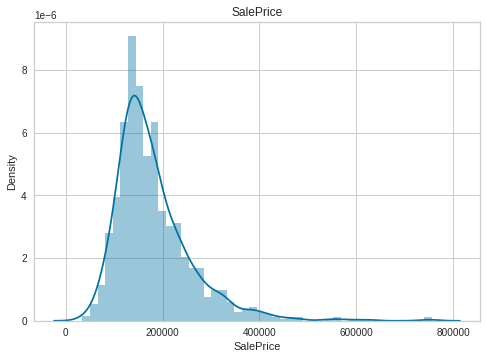

In [47]:
# Target Variable
fig, ax = plt.subplots()
sns.distplot(train['SalePrice'], ax=ax)
m = train['SalePrice'].mean()
print('Mean = {}'.format(m))
ax.set_title('SalePrice')

Mean = 181232.39126712328


Text(0.5, 1.0, 'SalePrice')

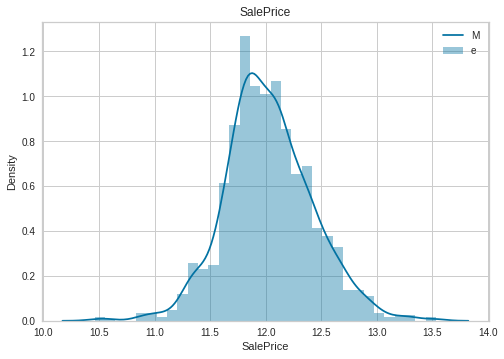

In [48]:
train['SalePrice'] = np.log1p(train['SalePrice'])
fig, ax = plt.subplots()
print('Mean = {}'.format(m))
sns.distplot(train['SalePrice'], ax=ax)
m = train['SalePrice'].mean()
ax.legend('Mean = {}'.format(m))
ax.set_title('SalePrice')

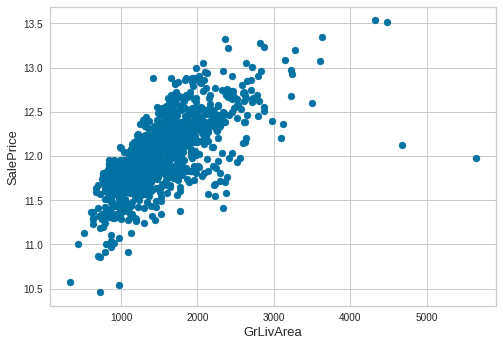

In [49]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [50]:
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# #Check the graphic again
# fig, ax = plt.subplots()
# ax.scatter(train['GrLivArea'], train['SalePrice'])
# plt.ylabel('SalePrice', fontsize=13)
# plt.xlabel('GrLivArea', fontsize=13)
# plt.show()

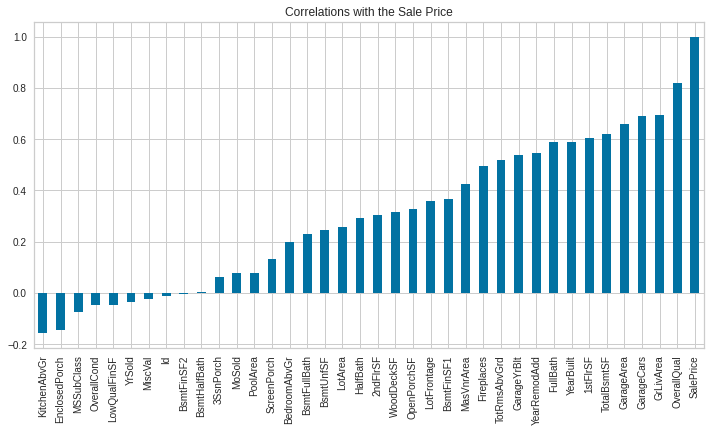

In [51]:
corr_with_SalePrice = train.corr()
plot_data = corr_with_SalePrice['SalePrice'].sort_values(ascending=True)
plt.figure(figsize=(12,6))
plot_data.plot.bar()
plt.title('Correlations with the Sale Price')
plt.show()
del plot_data

In [52]:
# drop_columns = ['Id']
drop_columns = ['Id', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']
train.drop(columns=drop_columns, axis=1, inplace=True)
test.drop(columns=drop_columns, axis=1, inplace=True)

In [53]:
train.duplicated().sum()

0

In [54]:
ntrain = train.shape[0]
ntest = test.shape[0]
Target = train['SalePrice']
Data = pd.concat((train, test)).reset_index(drop=True)
Data.drop(['SalePrice'], axis=1, inplace=True)
print("Data size is : {}".format(Data.shape))

Data size is : (1460, 75)


### Missing Data

The number of features that have missing values: 19


<AxesSubplot:>

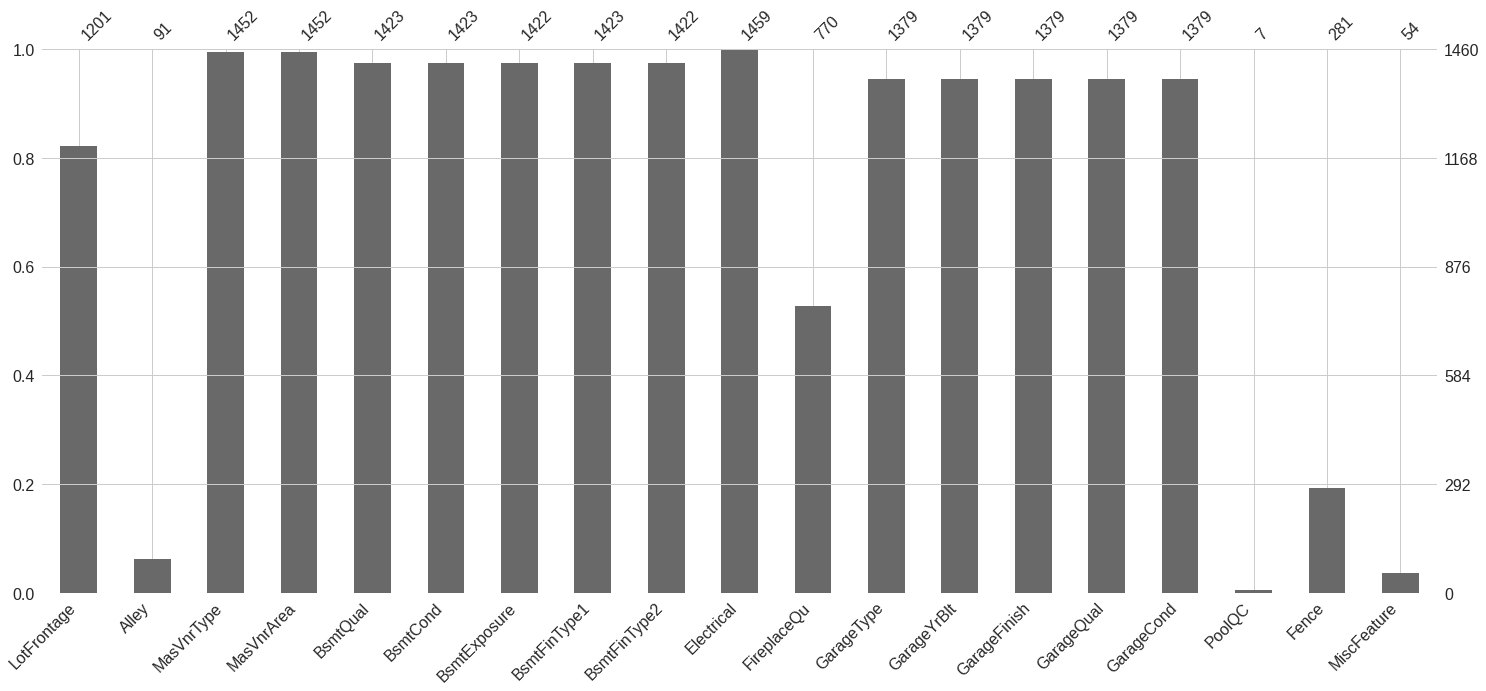

In [55]:
miss_features = [col for col in Data.columns.tolist() if Data[col].isnull().any()]
print('The number of features that have missing values: {}'.format(len(miss_features)))
msno.bar(Data[miss_features])
# miss_features = [col for col in train.columns.tolist() if train[col].isnull().any()]
# print('The number of features that have missing values in Train: {}'.format(len(miss_features)))
# display(msno.bar(train[miss_features]))

In [56]:
# miss_features = [col for col in test.columns.tolist() if test[col].isnull().any()]
# print('The number of features that have missing values in Test: {}'.format(len(miss_features)))
# display(msno.bar(test[miss_features]))

In [57]:
na_data = (Data.isnull().sum() / len(Data)) * 100
na_data = na_data.drop(na_data[na_data == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Percentage' :na_data})
missing_data.head(20)
# na_data = (train.isnull().sum() / len(train)) * 100
# na_data = na_data.drop(na_data[na_data == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Percentage' :na_data})
# missing_data.head(20)

,Missing Percentage
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [58]:
# na_data = (test.isnull().sum() / len(test)) * 100
# na_data = na_data.drop(na_data[na_data == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Percentage' :na_data})
# missing_data.head(20)

In [59]:
Data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)
# train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)
# test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)

In [60]:
corr = Data.corr()
print('LotFrontage correlation > .40: {}'.format(any(corr['LotFrontage'].sort_values(ascending=False).iloc[1:]>0.40)))
print(corr['LotFrontage'].sort_values(ascending=False).iloc[1:3])

LotFrontage correlation > .40: True
1stFlrSF    0.457181
LotArea     0.426095
Name: LotFrontage, dtype: float64


int64


<AxesSubplot:xlabel='1stFlrSF', ylabel='Density'>

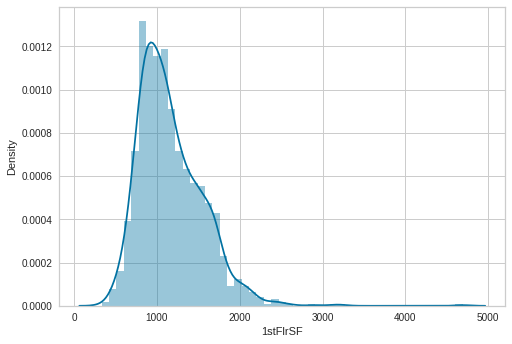

In [61]:
print(Data['1stFlrSF'].dtype)
sns.distplot(Data['1stFlrSF'])
# print(train['1stFlrSF'].dtype)
# sns.distplot(train['1stFlrSF'])

In [62]:
Data['1stFlrSF'].describe()
# train['1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [63]:
# # y = B0 + B1*x
# temp_df = Data[['LotFrontage', '1stFlrSF']].dropna()
# fill_miss = LinearRegression()
# fill_miss.fit(temp_df['1stFlrSF'].values.reshape(-1, 1), temp_df['LotFrontage'].values.reshape(-1, 1))
# B1, B0 = fill_miss.coef_[0][0], fill_miss.intercept_[0]
# print('Intercept = {} , Coefficient = {}'.format(B0, B1))
# for i in range(len(Data['LotFrontage'])):
#     if pd.isnull(Data.loc[i, 'LotFrontage']):
#         Data.loc[i, 'LotFrontage'] = B0 + (Data.loc[i, '1stFlrSF']*B1)

In [64]:
Data['LotFrontage'].fillna(Data['LotFrontage'].median(), inplace=True)
# train['LotFrontage'].fillna(train['LotFrontage'].median(), inplace=True)
# test['LotFrontage'].fillna(test['LotFrontage'].median(), inplace=True)
# Data['FireplaceQu'].fillna('None', inplace=True)
print('The number of Null values in LotFrontage: ', Data['LotFrontage'].isnull().sum())
# print('The number of Null values in LotFrontage: ', train['LotFrontage'].isnull().sum())
# print('The number of Null values in LotFrontage: ', test['LotFrontage'].isnull().sum())
# print('The number of Null values in FireplaceQu: ', Data['FireplaceQu'].isnull().sum())

The number of Null values in LotFrontage:  0


In [65]:
# 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2'
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    Data[col] = Data[col].fillna('None')
# for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
#     train[col] = train[col].fillna('None')
# for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
#     test[col] = test[col].fillna('None')

In [66]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    Data[col] = Data[col].fillna(0)
# for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
#     train[col] = train[col].fillna(0)
# for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
#     test[col] = test[col].fillna(0)

In [67]:
for col in ['BsmtFinSF1','BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath']:
    Data[col] = Data[col].fillna(0)
# for col in ['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath']:
    # train[col] = train[col].fillna(0)
# for col in ['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath']:
    # test[col] = test[col].fillna(0)

In [68]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    Data[col] = Data[col].fillna('None')
# for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
#     train[col] = train[col].fillna('None')
# for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
#     test[col] = test[col].fillna('None')

In [69]:
Data['MasVnrType'] = Data['MasVnrType'].fillna('None')
Data['MasVnrArea'] = Data['MasVnrArea'].fillna(0)
# train['MasVnrType'] = train['MasVnrType'].fillna('None')
# train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
# test['MasVnrType'] = test['MasVnrType'].fillna('None')
# test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [70]:
Data['Functional'].fillna('Typ', inplace=True)
# train['Functional'].fillna('Typ', inplace=True)
# test['Functional'].fillna('Typ', inplace=True)

In [71]:
# data description says NA means typical
Data['Electrical'].fillna(Data['Electrical'].mode()[0], inplace=True)
# train['Electrical'].fillna(train['Electrical'].mode()[0], inplace=True)

In [72]:
print('The number of missing values: ', sum(Data.isnull().sum()))
# print('The number of Train missing values: ', sum(train.isnull().sum()))
# print('The number of Test missing values: ', sum(test.isnull().sum()))

The number of missing values:  0


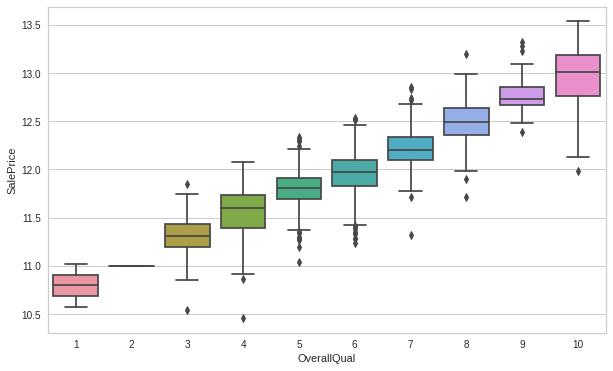

In [95]:
plt.figure(figsize=(10,6))
sns.boxplot(x="OverallQual", y="SalePrice", data=train);

<Figure size 1008x720 with 0 Axes>

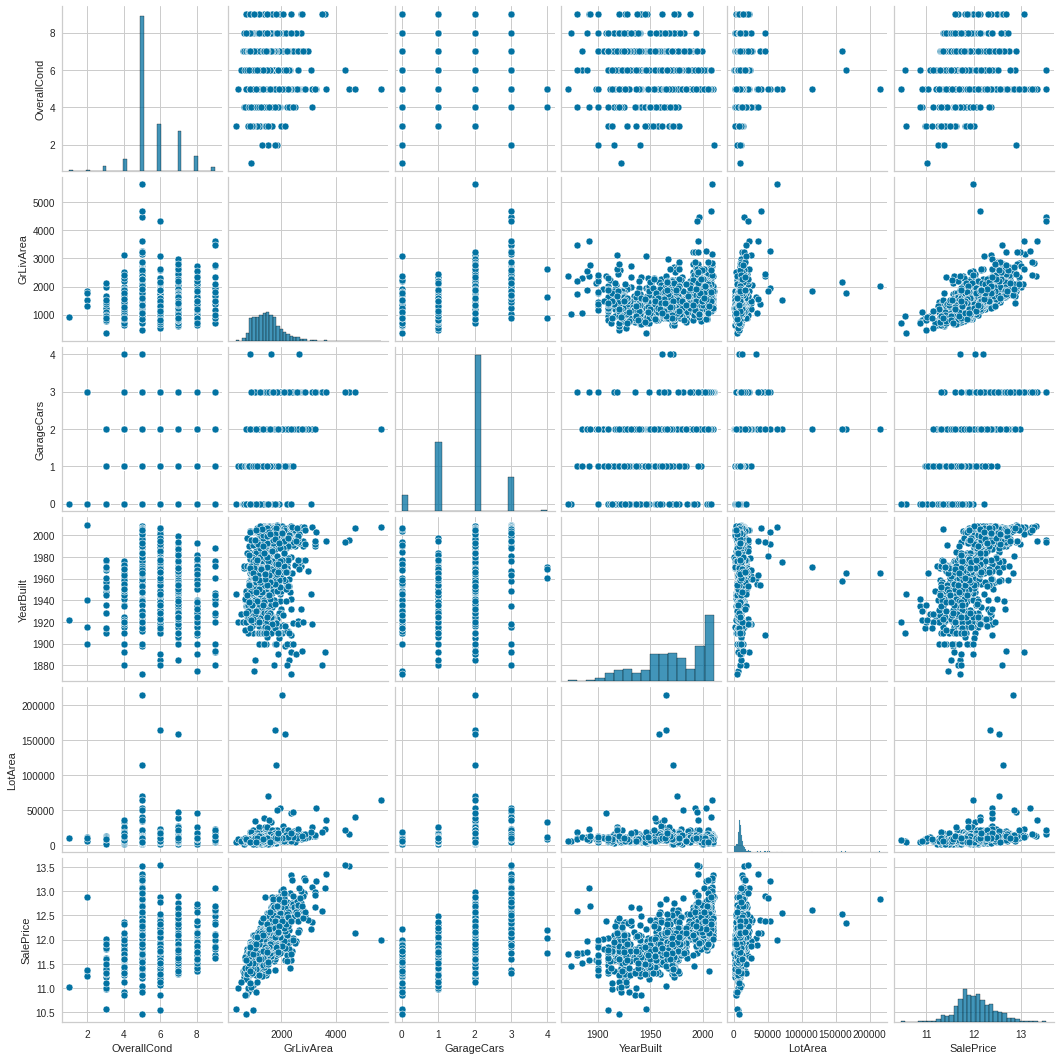

In [94]:
interesting_cols = ["OverallCond", "GrLivArea", "GarageCars", "YearBuilt", "LotArea", "SalePrice"]
plt.figure(figsize=(14,10))
sns.pairplot(train[interesting_cols], dropna=True);
del interesting_cols;

Text(0, 0.5, 'counts')

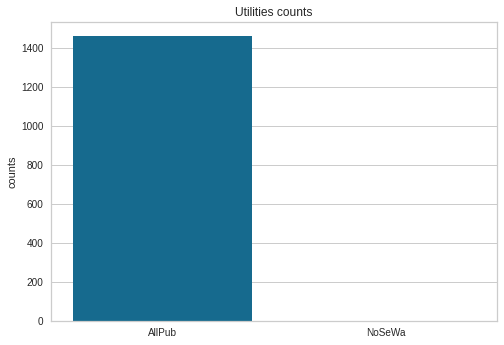

In [97]:
sns.barplot(x=Data['Utilities'].value_counts().index, y=Data['Utilities'].value_counts().values)
plt.title('Utilities counts')
plt.ylabel('counts')

In [36]:
print('Utilities value counts: \n', Data['Utilities'].value_counts())
Data.drop('Utilities', axis=1, inplace=True)
# train.drop('Utilities', axis=1, inplace=True)
# test.drop('Utilities', axis=1, inplace=True)

Utilities value counts: 
 AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


In [37]:
print('DType for YrSold is :', Data['YrSold'].dtype)
print('DType for MoSold is :', Data['MoSold'].dtype)
print('DType for YearBuilt is: ', Data['YearBuilt'].dtype)
# Data['YrSold'] = Data['YrSold'].astype("object")
# Data['MoSold'] = Data['MoSold'].astype("object")

DType for YrSold is : int64
DType for MoSold is : int64
DType for YearBuilt is:  int64


In [38]:
Data['TotalSF'] = Data['TotalBsmtSF'] + Data['1stFlrSF'] + Data['2ndFlrSF']
# train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
# test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [39]:
# Data["Age"] = Data['YrSold'] - Data['YearBuilt']
# Data.drop('YearBuilt', axis=1, inplace=True)

In [40]:
Data.shape
# print(train.shape)
# print(test.shape)

(1460, 70)

### Encoder

In [41]:
objectVar = Data.select_dtypes(include = ['object']).columns.tolist()
for col in objectVar:
    print('{} column has {} unique values'.format(col,Data[col].nunique()))

MSZoning column has 5 unique values
Street column has 2 unique values
LotShape column has 4 unique values
LandContour column has 4 unique values
LotConfig column has 5 unique values
LandSlope column has 3 unique values
Neighborhood column has 25 unique values
Condition1 column has 9 unique values
Condition2 column has 8 unique values
BldgType column has 5 unique values
HouseStyle column has 8 unique values
RoofStyle column has 6 unique values
RoofMatl column has 8 unique values
Exterior1st column has 15 unique values
Exterior2nd column has 16 unique values
MasVnrType column has 4 unique values
ExterQual column has 4 unique values
ExterCond column has 5 unique values
Foundation column has 6 unique values
BsmtQual column has 5 unique values
BsmtCond column has 5 unique values
BsmtExposure column has 5 unique values
BsmtFinType1 column has 7 unique values
BsmtFinType2 column has 7 unique values
Heating column has 6 unique values
HeatingQC column has 5 unique values
CentralAir column has 2

#### Ordinal

In [42]:
# 14 features
objVar = ['CentralAir', 'LandSlope', 'ExterQual', 'ExterCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
# objVar = train.select_dtypes(include = ['object']).columns.tolist()
encoder = LabelEncoder()
for col in objVar: 
    encoder.fit(list(Data[col].values)) 
    Data[col] = encoder.transform(list(Data[col].values))
print('Data Shape: ',Data.shape)
# for col in objVar: 
#     encoder.fit(list(train[col].values)) 
#     train[col] = encoder.transform(list(train[col].values))
# print('Train Shape: ',train.shape)
# for col in objVar: 
#     encoder.fit(list(test[col].values)) 
#     test[col] = encoder.transform(list(test[col].values))
# print('Test Shape: ',test.shape)

Data Shape:  (1460, 70)


In [43]:
num_fe = ['ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr', 'LandSlope', '3SsnPorch', 'LotArea', 'PoolArea']
skewed_feats = Data[num_fe].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
# skewed_feats = train[num_fe].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LandSlope,4.808735
KitchenAbvGr,4.483784
ScreenPorch,4.117977
EnclosedPorch,3.086696


In [44]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    Data[feat] = boxcox1p(Data[feat], lam)
# for feat in skewed_features:
#     #all_data[feat] += 1
#     train[feat] = boxcox1p(train[feat], lam)

There are 7 skewed numerical features to Box Cox transform


#### Non Ordinal

In [45]:
NonOrdinalVar = Data.select_dtypes(include = ['object']).columns.tolist()
Data = pd.get_dummies(Data, columns=NonOrdinalVar)
# one_hot = OneHotEncoder()
# for col in objectVar:
#     encoded = one_hot.fit_transform(train[[col]])
#     train[one_hot.categories_[0]]=encoded.toarray()
# train.drop(objectVar, axis=1, inplace=True)

In [46]:
# print('Number of Null values {}'.format(sum(Data.isnull().sum())))
# print('Train Shape {}'.format(Data.shape))

### Feature Selection

In [47]:
def correlation(df, threshold=None):
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = df.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

def reduce_data(df,comp_number=20):
    pca = PCA(n_components=comp_number, random_state=15).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    return reduced_data

In [48]:
# correlated_features = list(correlation(Data,threshold=0.56))
# Data = Data.drop(correlated_features, axis=1)
# Data = reduce_data(Data, 220)

In [49]:
train = Data[:ntrain]
test = Data[ntrain:]
print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

Train Shape:  (1168, 223)
Test Shape:  (292, 223)


In [50]:
# fig, ax = plt.subplots(figsize=(50,50))
# corr = pd.concat([train, Target], axis=1).corr()
# matrix = np.triu(corr)
# sns.heatmap(corr,
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,annot=True, cmap="BuPu", mask=matrix)
# best_feat = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
#        'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1',
#        'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', 'GrLivArea',
#        'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#        'GarageCars', 'GarageArea', 'GarageCond', 'OpenPorchSF', 'TotalSF',
#        'MSZoning_RM', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd',
#        'Exterior2nd_VinylSd', 'MasVnrType_None', 'Foundation_CBlock',
#        'Foundation_PConc', 'GarageType_Attchd', 'GarageType_Detchd',
#        'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None',
#        'GarageFinish_Unf', 'PavedDrive_Y', 'SaleType_New']

In [51]:
# df_corr = pd.concat([train, Target], axis=1)
# corelation=abs(df_corr.corr()['SalePrice']) >= 0.25
# best_features = corelation[corelation].index.tolist()
# best_features.remove('SalePrice')

In [52]:
# train = train[best_features]
# test = test[best_features]
# train = train[best_feat]
# test = test[best_feat]

In [53]:
# print('Train Shape: ', train.shape)
# print('Test Shape: ', test.shape)

In [54]:
# train.columns

In [55]:
# cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# fs = SelectKBest(score_func=mutual_info_regression)
# model =LinearRegression()
# pipeline = Pipeline(steps=[('sel',fs), ('model', model)])
# grid = dict()
# grid['sel__k'] = [i for i in range(5, 16)]
# search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# results = search.fit(train, Target.values)
# print('Best RMSE: %.3f' % results.best_score_)
# print('Best Config: %s' % results.best_params_)
# means = results.cv_results_['mean_test_score']
# params = results.cv_results_['params']
# for mean, param in zip(means, params):
#     print(">%.3f with: %r" % (np.sqrt(-mean), param))

In [56]:
# correlated_features = list(correlation(train,threshold=0.65))
# train = train.drop(correlated_features, axis=1)
# test = test.drop(correlated_features, axis=1)

In [57]:
# print('Train Shape: ', train.shape)
# print('Test Shape: ', test.shape)

In [58]:
# train.columns
# KitchenQual
# ExterQual
# train.drop('KitchenQual', axis=1, inplace=True)
# test.drop('KitchenQual', axis=1, inplace=True)

In [59]:
# for col in pd.concat([train, Target], axis=1).columns.to_list():
#     display(pd.concat([train, Target], axis=1).plot.scatter(x=col, y='SalePrice'))


### Split data

In [60]:
# Target = train['SalePrice'].copy()
# train = train.drop('SalePrice', axis=1)
X_train, X_val, y_train, y_val = train_test_split(train, Target.values, test_size = 0.25, random_state=42)

In [61]:
print('The shape of X_train', X_train.shape)
print('The shape of y_train', y_train.shape)
print('The shape of X_val', X_val.shape)
print('The shape of y_val', y_val.shape)

The shape of X_train (876, 223)
The shape of y_train (876,)
The shape of X_val (292, 223)
The shape of y_val (292,)


In [62]:
# def select_features(X_train, y_train, X_val, test):
#     fs = SelectKBest(score_func=mutual_info_regression, k=50)
#     fs.fit(X_train, y_train)
#     X_train_fs = fs.transform(X_train)
#     X_val_fs = fs.transform(X_val)
#     test_fs = fs.transform(test)
#     return X_train_fs, X_val_fs, test_fs, fs
# X_train, X_val, test, fs = select_features(X_train, y_train, X_val, test)
# fig, ax = plt.subplots(figsize=(12,7))
# plt.title('input features score')
# plt.xlabel('number of features')
# plt.ylabel('scores')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
# plt.show()

In [63]:
# def select_features(X_train, y_train, X_val, test):
#     fs = SelectKBest(score_func=f_regression, k=29)
#     fs.fit(X_train, y_train)
#     X_train_fs = fs.transform(X_train)
#     X_val_fs = fs.transform(X_val)
#     test_fs = fs.transform(test)
#     return X_train_fs, X_val_fs, test_fs, fs
# X_train, X_val, test, fs = select_features(X_train, y_train, X_val, test)
# fig, ax = plt.subplots(figsize=(12,7))
# plt.title('input features score')
# plt.xlabel('number of features')
# plt.ylabel('scores')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
# plt.show()

### Scaling

In [64]:
# scale = StandardScaler().fit(X_train)
# X_train = scale.transform(X_train)

### Test Models

#### SVR

In [65]:
svr = SVR()
svr.fit(X_train, y_train)
pred = svr.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.17120439943728016


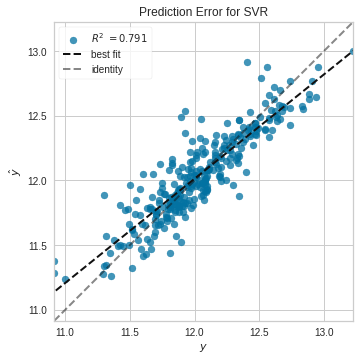

<AxesSubplot:title={'center':'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

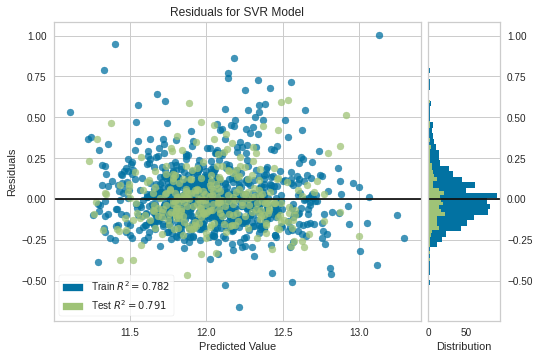

<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
visualizer = PredictionError(svr)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(svr)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

#### Linear Regression

In [67]:
lin = LinearRegression()
lin.fit(X_train, y_train)
pred = lin.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.12229392017062524


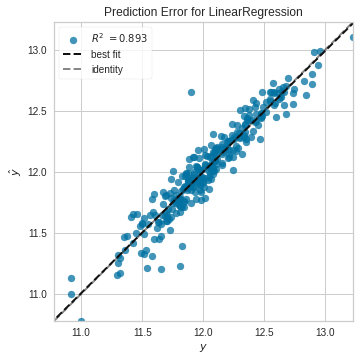

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

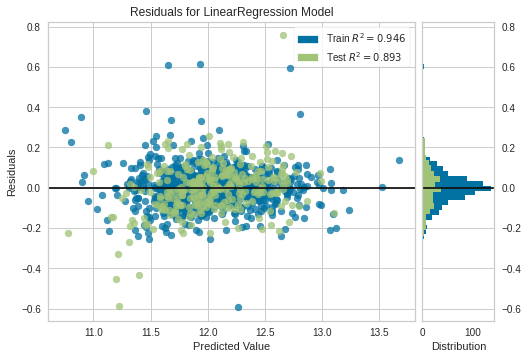

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [68]:
visualizer = PredictionError(lin)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(lin)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

#### Lasso

In [69]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.1573547770879241


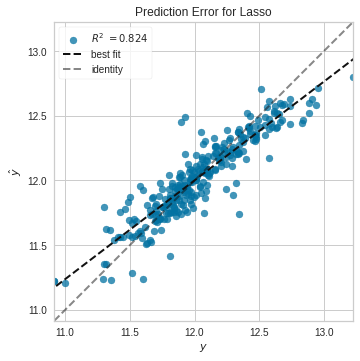

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

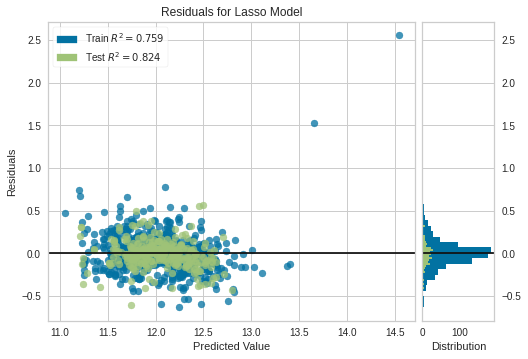

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [70]:
visualizer = PredictionError(lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

#### Random Forest

In [71]:
ran = RandomForestRegressor(random_state=11)
ran.fit(X_train, y_train)
pred = ran.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.13062224290811816


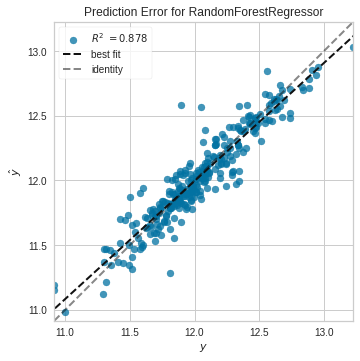

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

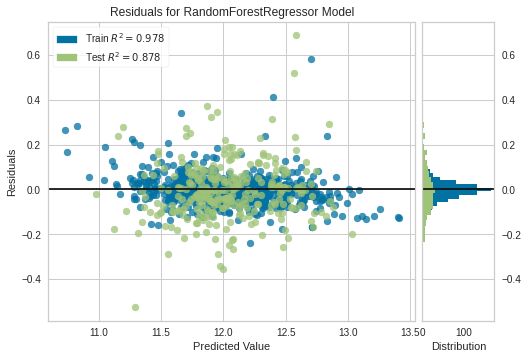

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [72]:
visualizer = PredictionError(ran)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(ran)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

#### XGboost

In [73]:
xgb = XGBRegressor(random_state=7)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.12107602407463845


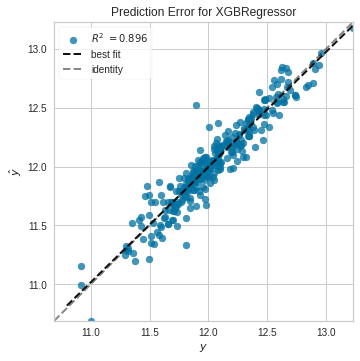

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

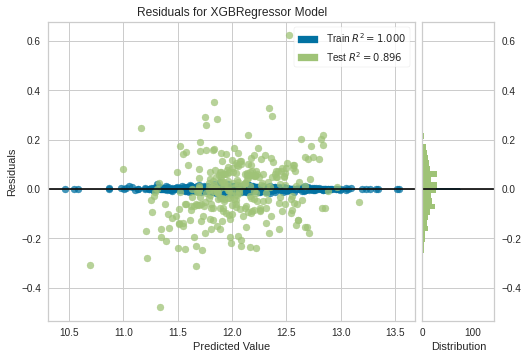

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [74]:
visualizer = PredictionError(xgb)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(xgb)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

#### LGBM

In [75]:
lgbm = LGBMRegressor(random_state=11)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.11882011350856043


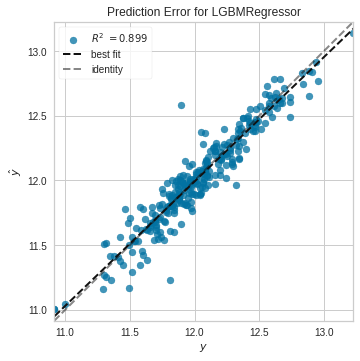

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

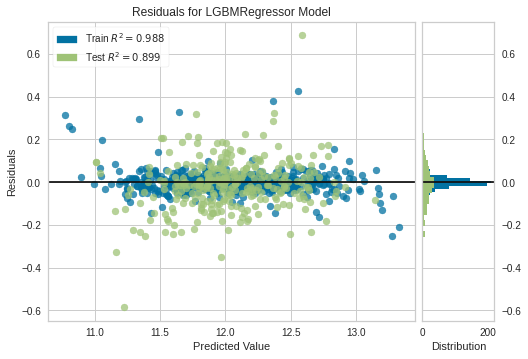

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [76]:
visualizer = PredictionError(lgbm)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(lgbm)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

### Tuning Model

#### SVR Tuning

In [77]:
# parameters = {
#               'kernel': ['rbf'],
#               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
#               'C': [1, 10, 100, 1000, 10000]
#              }
# # scorer = make_scorer(mean_squared_error, greater_is_better=False)
# fold = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train)
# svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = fold, scoring='neg_mean_squared_error')
# svr_gs.fit(X_train, y_train)
# print('Best_Estimator: ', svr_gs.best_estimator_)
# print('*********************************************')
# scores = svr_gs.cv_results_
# for mean_score, params in zip(scores['mean_test_score'], scores['params']):
#     print(np.sqrt(-mean_score), params)

In [78]:
# model0 = svr_gs.best_estimator_
# model0.fit(X_train, y_train)
# pred = model0.predict(X_val)
# print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

In [79]:
# visualizer = PredictionError(model0)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())
# visualizer = ResidualsPlot(model0)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())

#### Lasso Tuning

In [80]:
# param_grid ={'alpha':[0.0, 0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 1, 10, 100, 1000]}
# lasso = Lasso(random_state=1)
# fold = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train)
# lasso_grid_search = GridSearchCV(lasso, param_grid, cv=fold, scoring='neg_mean_squared_error')
# lasso_grid_search.fit(X_train, y_train)
# print('Best_Estimator: ', lasso_grid_search.best_estimator_)
# print('*********************************************')
# scores = lasso_grid_search.cv_results_
# for mean_score, params in zip(scores['mean_test_score'], scores['params']):
#     print(np.sqrt(-mean_score), params)

In [81]:
# model = Lasso(alpha=0.5)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)
# print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

#### Random Forest Tuning

In [82]:
# forest_reg = RandomForestRegressor(random_state=11)
# n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 5)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# min_samples_split = [3, 5, 7, 9, 11, 15]
# param_grid = {'bootstrap': [True, False],
#               'min_samples_split': min_samples_split,
#               'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth':max_depth
#              }
# fold = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train)
# ranf_grid_search = GridSearchCV(forest_reg, param_grid, cv=fold, scoring='neg_mean_squared_error')
# ranf_grid_search.fit(X_train, y_train)
# print('Best_Estimator: ', ranf_grid_search.best_estimator_)
# print('*********************************************')
# scores = ranf_grid_search.cv_results_
# for mean_score, params in zip(scores['mean_test_score'], scores['params']):
#     print(np.sqrt(-mean_score), params)

In [83]:
# model1 = ranf_grid_search.best_estimator_
# pred = model1.predict(X_val)
# print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

In [84]:
# visualizer = PredictionError(model1)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())
# visualizer = ResidualsPlot(model1)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())

#### XGBoost Regrission Tuning

In [85]:
# param_grid = {'eval_metric'      : ['rmse'],
#               'n_estimators'     : [1000],
#               'learning_rate'    : [0.05, 0.03, 0.5, 0.10, 0.15, 0.2] ,
#               'max_depth'        : [3, 5, 6, 7, 8, 9, 11],
#               'min_child_weight' : [ 5, 7, 9, 11, 13, 15],
#               'subsample'        : [i/10.0 for i in range(6,10)],
#               'gamma'            : [ 0.0, 0.1, 0.2],
#               'colsample_bytree' : [i/10.0 for i in range(6,10)],
#               'reg_alpha'        : [1e-5, 1e-2, 0.1, 1, 100]}
# xgb = XGBRegressor()
# fold = KFold(n_splits=3, shuffle=True, random_state=42).split(X_train, y_train)
# xgb_grid_search = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, n_iter = 50, cv =fold , random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# xgb_grid_search.fit(X_train, y_train)
# print('Best_Estimator: ', xgb_grid_search.best_estimator_)
# print('*********************************************')
# scores = xgb_grid_search.cv_results_
# for mean_score, params in zip(scores['mean_test_score'], scores['params']):
#     print(np.sqrt(-mean_score), params)

In [86]:
# model2 = xgb_grid_search.best_estimator_
# pred = model2.predict(X_val)
# print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

In [87]:
# visualizer = PredictionError(model2)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())
# visualizer = ResidualsPlot(model2)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_val, y_val)
# display(visualizer.poof())

#### LightGBM Tuning

In [88]:
param_grid = { 
                'metric': 'rmse',
                'n_estimators': [9000],
                'boosting_type': ["gbdt", "goss"],
                'reg_alpha': [0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
                'reg_lambda': [0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'subsample': [0.6, 0.7, 0.85, 1.0],
                'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05, 0.1],
                'max_depth': list(range(2, 12, 1)),
                'num_leaves' : list(range(13, 148, 5)),
                'min_child_samples': list(range(1, 96, 5)),
            }
lgbm = LGBMRegressor(random_state=11)
fold = KFold(n_splits=3, shuffle=True, random_state=42).split(X_train, y_train)
lgbm_grid_search = RandomizedSearchCV(estimator = lgbm, param_distributions = param_grid, n_iter = 50, cv =fold , random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
lgbm_grid_search.fit(X_train, y_train)
print('Best_Estimator: ', lgbm_grid_search.best_estimator_)
print('*********************************************')
scores = lgbm_grid_search.cv_results_
for mean_score, params in zip(scores['mean_test_score'], scores['params']):
    print(np.sqrt(-mean_score), params)

Best_Estimator:  LGBMRegressor(colsample_bytree=0.6, learning_rate=0.005, max_depth=3,
              metric='r', min_child_samples=1, n_estimators=9000,
              num_leaves=108, random_state=11, reg_alpha=0.01,
              reg_lambda=0.005)
*********************************************
0.13523511782497719 {'subsample': 1.0, 'reg_lambda': 0.05, 'reg_alpha': 0.1, 'num_leaves': 118, 'n_estimators': 9000, 'min_child_samples': 11, 'metric': 's', 'max_depth': 2, 'learning_rate': 0.02, 'colsample_bytree': 0.5, 'boosting_type': 'goss'}
0.14543802803147907 {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.005, 'num_leaves': 43, 'n_estimators': 9000, 'min_child_samples': 16, 'metric': 'r', 'max_depth': 11, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'boosting_type': 'goss'}
0.1387687755222426 {'subsample': 0.85, 'reg_lambda': 0.01, 'reg_alpha': 0.001, 'num_leaves': 28, 'n_estimators': 9000, 'min_child_samples': 6, 'metric': 'e', 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytr

In [89]:
model3 = lgbm_grid_search.best_estimator_
pred = model3.predict(X_val)
print('The RMSE {}'.format(np.sqrt(mean_squared_error(y_val, pred))))

The RMSE 0.11168570609883828


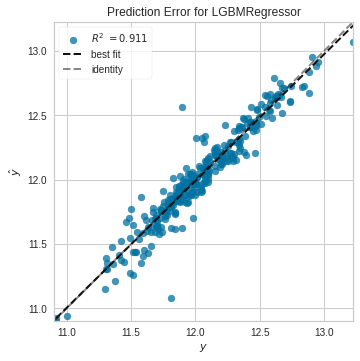

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

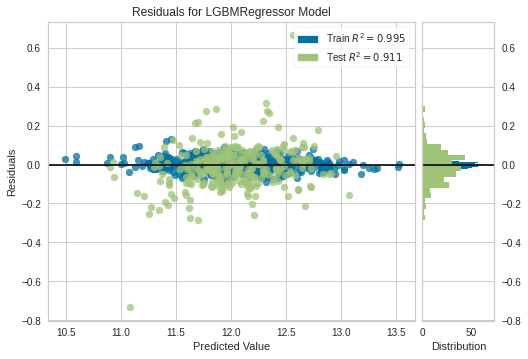

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [90]:
visualizer = PredictionError(model3)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())
visualizer = ResidualsPlot(model3)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
display(visualizer.poof())

### Predict Test Data

In [91]:
test_pre = model3.predict(test)
print('The Range is:   {} - {}'.format(min(test_pre), max(test_pre)))

The Range is:   10.993791536281597 - 13.015165432904528


In [92]:
test_pre = np.expm1(test_pre)
print('The Range is:   {} - {}'.format(min(test_pre), max(test_pre)))

The Range is:   59502.566819403575 - 449172.91618863674


### CSV sub

In [93]:
# sub['SalePrice'] = test_pre
# sub.to_csv('sub5.csv', index=False)